## Import

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # nvidia-smi로 비어있는 gpu 확인하고 여기서 선택할것!

In [2]:
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/leadawon5/dawon/visionvenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Utils

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        print("full dataset size : ",len(self.data))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        img_path = "../data"+self.data.iloc[idx, 1][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        # mask_rle = self.data.iloc[idx, 2]
        # mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        # if self.transform:
        #     augmented = self.transform(image=image, mask=mask)
        #     image = augmented['image']
        #     mask = augmented['mask']

        # return image, mask
        assert False , "SatelliteDataset class must be used as test dataset obj"

In [5]:
class TV_SatelliteDataset(Dataset):
    def __init__(self,transform=None, is_train = True):
        self.is_train = is_train
        
        self.transform = transform
    def __len__(self):
        if self.is_train:
            return 114240-11424  ###### 조심할것.
        return 11424

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        if not self.is_train:
            idx += 102816
        img_path = "../split_data_224/train_img"+f"/{idx//16}_{idx%16}.png"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = "../split_data_224/train_mask"+f"/{idx//16}_{idx%16}.png"
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        #print("hello" , mask.shape)

        
        #print("hello" , mask.shape)

        
        #assert fsize != lsize , f"{fsize} should be different from {lsize}"

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [6]:
transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = TV_SatelliteDataset(transform=transform, is_train=True)
val_dataset = TV_SatelliteDataset(transform=transform, is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


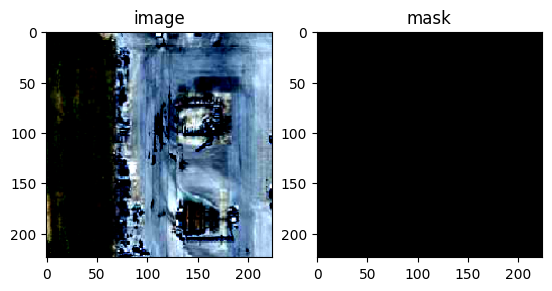

In [7]:
def printdataset(dataset,idx = 0):
    clear_output()
    sample = dataset[idx]
    image, mask = sample
    print(type(image))
# 이미지와 마스크 시각화
    plt.subplot(1, 2, 1)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title("image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("mask")
    plt.show()
    #print(len(image),len(image[0]), len(mask), len(mask[0]))
    #print(mask.shape)
    #print(image.shape)
    time.sleep(1)
for i in range(4):
    printdataset(train_dataset, i)

## Define Model

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'): # out_class 1???
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

## Model Train

In [8]:
dice_loss = smp.losses.DiceLoss(mode='binary')

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
#CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
# model 초기화
# model = UNet().to(device)

# backbone resnet
# model = smp.Unet("resnet34" , encoder_weights="imagenet", activation=None, in_channels=3, classes=1)
# for name, p in model.named_parameters():
#     if "encoder" in name:
#         p.requires_grad = False

model.to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# validation
best_validation_loss = 200.0

# training loop
for epoch in range(20):  # 10 에폭 동안 학습합니다.
    print(f'======Epoch {epoch+1} =======')
    model.train()
    epoch_loss = 0
    val_loss = 0
    for images, masks in tqdm(train_dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images = images.float().to(device)
            score_masks = masks.unsqueeze(1)
            masks = masks.float().to(device)
            outputs = model(images)
            #score
            score_masks = score_masks.to(device)
            tp, fp, fn, tn = smp.metrics.get_stats(outputs, score_masks, mode='binary', threshold=0.35)
            f1 = smp.metrics.f1_score(tp, fp, fn, tn)
            iou = smp.metrics.iou_score(tp, fp, fn, tn)
            accu = smp.metrics.accuracy(tp,fp, fn, tn)
            dice_score = 1 - dice_loss(outputs, score_masks)
            #loss
            loss = criterion(outputs, masks.unsqueeze(1))
            val_loss += loss.item()
    
    if best_validation_loss > val_loss/len(val_dataloader):
        best_validation_loss = val_loss/len(val_dataloader)
        torch.save(model, f'../best_model/best_model.pth')
        print('Model saved!')
    print(f'Epoch {epoch+1}, Train_Loss: {epoch_loss/len(train_dataloader)}, Val_Loss: {val_loss/len(val_dataloader)}')
    print(f'IoU Score : {torch.mean(iou)} f1 Score : {torch.mean(f1)} accuracy: {torch.mean(accu)}')
    print(f'Dice score : {dice_score}')

======Epoch 1 =======


100%|██████████| 714/714 [01:26<00:00,  8.26it/s]


Model saved!
Epoch 1, Train_Loss: 0.6871919586878865, Val_Loss: 0.6843208662268161
IoU Score : 0.5575813055038452 f1 Score : 0.6634283661842346 accuracy: 0.9666286706924438
Dice score : 0.12749969959259033
======Epoch 2 =======


100%|██████████| 714/714 [01:27<00:00,  8.19it/s]


Model saved!
Epoch 2, Train_Loss: 0.6835671214904512, Val_Loss: 0.6831448489711398
IoU Score : 0.570683479309082 f1 Score : 0.6570141315460205 accuracy: 0.9730374217033386
Dice score : 0.20560979843139648
======Epoch 3 =======


100%|██████████| 714/714 [00:25<00:00, 27.48it/s]


Model saved!
Epoch 3, Train_Loss: 0.6829012978533292, Val_Loss: 0.6821546858432246
IoU Score : 0.5735272169113159 f1 Score : 0.666053056716919 accuracy: 0.9780423045158386
Dice score : 0.09021472930908203
======Epoch 4 =======


100%|██████████| 714/714 [00:26<00:00, 27.10it/s]


Model saved!
Epoch 4, Train_Loss: 0.6821136357366501, Val_Loss: 0.6811720207959664
IoU Score : 0.589540958404541 f1 Score : 0.6858274936676025 accuracy: 0.9853938817977905
Dice score : 0.08416390419006348
======Epoch 5 =======


100%|██████████| 714/714 [00:26<00:00, 27.44it/s]


Model saved!
Epoch 5, Train_Loss: 0.6816939209207284, Val_Loss: 0.6809948877293188
IoU Score : 0.7003026604652405 f1 Score : 0.7738932371139526 accuracy: 0.9774755239486694
Dice score : 0.12673592567443848
======Epoch 6 =======


100%|██████████| 714/714 [00:26<00:00, 27.34it/s]


Epoch 6, Train_Loss: 0.6814247989372565, Val_Loss: 0.6810531957643706
IoU Score : 0.7046521306037903 f1 Score : 0.7466621398925781 accuracy: 0.9794049859046936
Dice score : 0.10518324375152588
======Epoch 7 =======


100%|██████████| 714/714 [00:36<00:00, 19.52it/s]


Model saved!
Epoch 7, Train_Loss: 0.6812160218240612, Val_Loss: 0.6808327352132449
IoU Score : 0.6488742828369141 f1 Score : 0.7439441680908203 accuracy: 0.9742244482040405
Dice score : 0.15880107879638672
======Epoch 8 =======


100%|██████████| 714/714 [00:36<00:00, 19.59it/s]


Model saved!
Epoch 8, Train_Loss: 0.680924745185554, Val_Loss: 0.6803172160597408
IoU Score : 0.5688615441322327 f1 Score : 0.6614406108856201 accuracy: 0.9517161846160889
Dice score : 0.18096548318862915
======Epoch 9 =======


100%|██████████| 714/714 [00:36<00:00, 19.30it/s]


Epoch 9, Train_Loss: 0.6806837243155234, Val_Loss: 0.6810424545732867
IoU Score : 0.5847055315971375 f1 Score : 0.6831133365631104 accuracy: 0.9796117544174194
Dice score : 0.10745358467102051
======Epoch 10 =======


100%|██████████| 714/714 [00:38<00:00, 18.75it/s]


Epoch 10, Train_Loss: 0.6806550289736408, Val_Loss: 0.6805649743694551
IoU Score : 0.6313841342926025 f1 Score : 0.7277101278305054 accuracy: 0.982759416103363
Dice score : 0.13352042436599731
======Epoch 11 =======


100%|██████████| 714/714 [00:36<00:00, 19.79it/s]


Model saved!
Epoch 11, Train_Loss: 0.6802958721614426, Val_Loss: 0.6800436513597558
IoU Score : 0.7155255675315857 f1 Score : 0.7981297373771667 accuracy: 0.9781967401504517
Dice score : 0.176380455493927
======Epoch 12 =======


100%|██████████| 714/714 [00:35<00:00, 19.85it/s]


Epoch 12, Train_Loss: 0.6802937770943533, Val_Loss: 0.680159274102593
IoU Score : 0.5578480362892151 f1 Score : 0.6275774240493774 accuracy: 0.9763919115066528
Dice score : 0.07147353887557983
======Epoch 13 =======


100%|██████████| 714/714 [00:37<00:00, 19.01it/s]


Model saved!
Epoch 13, Train_Loss: 0.6800833951451123, Val_Loss: 0.6799019757105189
IoU Score : 0.6917942762374878 f1 Score : 0.779201090335846 accuracy: 0.9783188104629517
Dice score : 0.169805645942688
======Epoch 14 =======


100%|██████████| 714/714 [00:36<00:00, 19.66it/s]


Epoch 14, Train_Loss: 0.6799674424804559, Val_Loss: 0.6803063359581122
IoU Score : 0.5145373940467834 f1 Score : 0.5713483095169067 accuracy: 0.9794759750366211
Dice score : 0.0827188491821289
======Epoch 15 =======


100%|██████████| 714/714 [00:36<00:00, 19.69it/s]


In [11]:
model = torch.load('../best_model/best_model.pth')
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Inference

In [12]:
test_dataset = SatelliteDataset(csv_file='../data/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

full dataset size :  60640


In [13]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

  2%|▏         | 58/3790 [00:02<02:16, 27.25it/s]

100%|██████████| 3790/3790 [02:05<00:00, 30.13it/s]


## Submission

In [14]:
submit = pd.read_csv('../data/sample_submission.csv')
submit['mask_rle'] = result

In [15]:
submit.to_csv('../submit/submit_UNET_bbrn34_16split.csv', index=False)